# Final Project

## Task 1: Load the Data

For this final project, I will be using the fashion MNIST data, which has been split up to use as either the training or testing dataset for the ML models. Each row in the fashion dataset represents a single 28x28 gray-scale image of some item of clothing. The first column is a label (from 0 to 9), representing a unique item of clothing. The remaining columns represent a value for one of the 784 pixels that make up this image. To train the ML models I will be creating further below in this project, 60,000 images have been reserved. The training dataset contains 10,000 images.

In [1]:
#loading test and training files for fashion MNIST
import pandas as pd
fashion_test = pd.read_csv('fashion-mnist_test.csv')
fashion_train = pd.read_csv('fashion-mnist_train.csv')

## Fashion Training Data

In [2]:
#fashion training data
X_train = fashion_train.iloc[:,1:].to_numpy()
y_train = fashion_train.iloc[:,0].to_numpy()
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (60000, 784)
y_train shape:  (60000,)


## Fashion Test Data

In [3]:
#fashion test data
X_test = fashion_test.iloc[:,1:].to_numpy()
y_test = fashion_test.iloc[:,0].to_numpy()
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_test shape:  (10000, 784)
y_test shape:  (10000,)


To better visualize the data I will be working with, I have taken a sample image of each of the 10 categories. The goal of the ML models then will be to analyze a new gray-scale image and decide what item of clothing is shown in it, based on what it has learned in the training dataset.

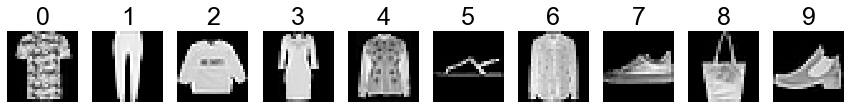

In [20]:
import numpy as np
import matplotlib.pyplot as plt
_, axes = plt.subplots(1,10, figsize=(15, 12)) # 1 row of 10 images lined up together
axes = axes.reshape(-1)    # make each axis accessible in a linear fashion

# get indices of each unique category (labeled from 0 to 9)
index_list = []
for i in range(10):
    index = np.where(y_train==i)[0][0] # get the first index that contains category i (0 to 9) 
    index_list.append(index)

for i in range(10):
    axes[i].axis('off') # hide the axes
    axes[i].imshow(X_train[index_list[i],:].reshape(28,28), cmap = 'gray')      # display as 28x28 grayscale image
    axes[i].set_title(str(y_train[index_list[i]]), color= 'black', fontsize=25) # title is label
plt.show()

## Task 2: Logistic Regression

Since the fashion dataset involves labeling images with the proper category, and there are 10 categories in total, this problem requires multi-class logistic regression. The class below uses Python and Numpy to take in the data containing pixel information of the sample images, and finds the best parameters to create a model that will predict the correct clothing label for new images.

In [5]:
import numpy as np

class myLogisticRegression():
    """ 
    Multi-class Logistic Regression
    """
    def __init__(self, learning_rate=.001, num_epochs = 15, size_batch = 30):
        '''
        Initialize multi-class logistic regression w/the learning rate, number of epochs, and size of mini-batch for SGD
        '''
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.size_batch = size_batch
        
        
    def fit(self, data, y, n_iterations = 1000):
        '''
        Uses SGD to find the optimized parameter beta
        data: pixel values for sample images 
        y: list of class labels for each of the sample images
        n_iterations: number of iterations for SGD
        '''
        self.K = max(y)+1
        ones = np.ones((data.shape[0],1)) 
        X = np.concatenate((ones, data), axis = 1)
        eta = self.learning_rate  # step size 
        
        beta  = np.zeros((np.shape(X)[1],max(y)+1)) 
        
        N = X.shape[0] # number of training samples
        num_epochs = self.num_epochs
        size_batch = self.size_batch
        num_iter = 0
        for e in range(num_epochs):
            shuffle_index = np.random.permutation(N) # in each epoch, we first reshuffle the data to create "randomness"
            for m in range(0,N,size_batch):   # m is the starting index of mini-batch
                i = shuffle_index[m:m+size_batch] # index of samples in the mini-batch
                dbeta = self.loss_gradient(beta,X[i,:],y[i]) # only use the data in mini-batch to compute gradient. Note the average is taken in the loss_gradient function
                beta = beta - eta * dbeta # the formula of GD, but this time dbeta is different

                if e % 1 == 0 and num_iter % 100 ==0: 
                    print("loss after", e+1, "epochs and ", num_iter+1, "iterations is: ", self.loss(beta,X,y))

                num_iter = num_iter +1 
        
        self.coeff = beta
        
    def predict(self, data):
        '''
        Returns the predicted y labels given the data
        data: pixel values for sample images 
        '''
        ones = np.ones((data.shape[0],1)) 
        X = np.concatenate((ones, data), axis = 1) 
        beta = self.coeff 
        y_pred = np.argmax(self.sigma(X,beta), axis =1)
        return y_pred
    
    def score(self, data, y_true):
        '''
        Returns the accuracy of label prediction
        data: pixel values for sample images 
        y_true: list of correct class labels for each of the sample images
        '''
        ones = np.ones((data.shape[0],1)) # column of ones
        X = np.concatenate((ones, data), axis = 1) # tilde X
        y_pred = self.predict(data)
        acc = np.mean(y_pred == y_true) # number of correct predictions / total number of samples
        return acc
    
    def sigma(self,X,beta): 
        '''
        Returns soft-max probability
        X: matrix of all the sample images
        beta: optimized beta found through SGD
        '''
        s = np.exp(np.matmul(X,beta))
        total = np.sum(s, axis=1).reshape(-1,1)
        return s/total

    def loss(self,beta,X,y):
        '''
        Returns loss function using cross entropy
        beta: optimized beta found through SGD
        X: matrix of all the sample images
        y: list of class labels for each of the sample images
        '''
        f_value = self.sigma(X,beta)
        K = self.K 
        loss_vector = np.zeros(X.shape[0])
        for k in range(K):
            loss_vector += np.log(f_value+1e-10)[:,k] * (y == k) 
        return -np.mean(loss_vector)
                          
    def loss_gradient(self,beta,X,y):
        '''
        Return output is (p,K) weight update matrix for gradient descent
        beta: optimized beta found through SGD
        X: matrix of all the sample images
        y: list of class labels for each of the sample images
        '''
        f_value = self.sigma(X,beta)
        K = self.K 
        dLdW = np.zeros((X.shape[1],K))
        for k in range(K):
            dLdWk =(f_value[:,k] - (y==k)).reshape(-1,1)*X 
            dLdW[:,k] = np.mean(dLdWk, axis=0)   
        return dLdW

In [6]:
model = myLogisticRegression(learning_rate=1e-6, num_epochs = 15, size_batch = 30)
model.fit(X_train,y_train,n_iterations = 15000)

loss after 1 epochs and  1 iterations is:  2.172603650556351
loss after 1 epochs and  101 iterations is:  0.8224605081130734
loss after 1 epochs and  201 iterations is:  0.7921008136311325
loss after 1 epochs and  301 iterations is:  0.7007981889250784
loss after 1 epochs and  401 iterations is:  0.6127531173093634
loss after 1 epochs and  501 iterations is:  0.5981812664637824
loss after 1 epochs and  601 iterations is:  0.6005492529445627
loss after 1 epochs and  701 iterations is:  0.5744726214651925
loss after 1 epochs and  801 iterations is:  0.5874265440254639
loss after 1 epochs and  901 iterations is:  0.5535624208216356
loss after 1 epochs and  1001 iterations is:  0.5448380324600688
loss after 1 epochs and  1101 iterations is:  0.5460974193969629
loss after 1 epochs and  1201 iterations is:  0.5280396544474544
loss after 1 epochs and  1301 iterations is:  0.5309767472087268
loss after 1 epochs and  1401 iterations is:  0.5645940501203824
loss after 1 epochs and  1501 iteratio

loss after 7 epochs and  12601 iterations is:  0.4363627539529928
loss after 7 epochs and  12701 iterations is:  0.47279811978618264
loss after 7 epochs and  12801 iterations is:  0.4606305111998801
loss after 7 epochs and  12901 iterations is:  0.4301109501936551
loss after 7 epochs and  13001 iterations is:  0.4450164759019223
loss after 7 epochs and  13101 iterations is:  0.45297467309807016
loss after 7 epochs and  13201 iterations is:  0.436676440730458
loss after 7 epochs and  13301 iterations is:  0.4615814104360536
loss after 7 epochs and  13401 iterations is:  0.43252722830800067
loss after 7 epochs and  13501 iterations is:  0.45748217786762835
loss after 7 epochs and  13601 iterations is:  0.4477291259064741
loss after 7 epochs and  13701 iterations is:  0.45974089569951593
loss after 7 epochs and  13801 iterations is:  0.44419861100564006
loss after 7 epochs and  13901 iterations is:  0.43707084639849453
loss after 8 epochs and  14001 iterations is:  0.43750166618867614
los

loss after 13 epochs and  24901 iterations is:  0.4153036479098001
loss after 13 epochs and  25001 iterations is:  0.4111610440118092
loss after 13 epochs and  25101 iterations is:  0.43669280961979123
loss after 13 epochs and  25201 iterations is:  0.40796219233726255
loss after 13 epochs and  25301 iterations is:  0.4283524717364666
loss after 13 epochs and  25401 iterations is:  0.4160853151532877
loss after 13 epochs and  25501 iterations is:  0.43120961763957305
loss after 13 epochs and  25601 iterations is:  0.44481891593804784
loss after 13 epochs and  25701 iterations is:  0.4447853484385671
loss after 13 epochs and  25801 iterations is:  0.41596331446582197
loss after 13 epochs and  25901 iterations is:  0.4241753101511411
loss after 14 epochs and  26001 iterations is:  0.41805391165170497
loss after 14 epochs and  26101 iterations is:  0.41669619133656344
loss after 14 epochs and  26201 iterations is:  0.44789451488719784
loss after 14 epochs and  26301 iterations is:  0.4210

## Multi-class Logistic Regression Model Performance

In [7]:
model.score(X_test,y_test) #score the performance of the model with the x and y test dataset

0.8459

According to the cell above, the model accurately predicted the correct label of clothing for 84.59% of the test dataset. For 10,000 new images, the model's performance is satisfactory. In the following cells below, we will see what type of mistakes the model has made.

In [8]:
y_test_pred = model.predict(X_test) #predicted y labels after giving the trained model the x test dataset

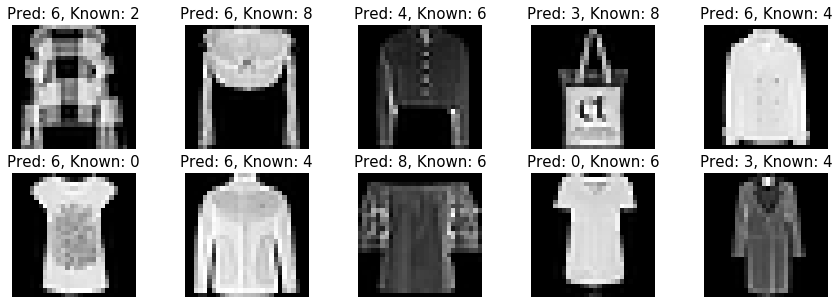

In [9]:
mislabelled = np.nonzero(y_test_pred!=y_test)[0]
idx=np.random.choice(mislabelled,size=10)   # choose 10 from mislabelled images

_, axes = plt.subplots(2,5, figsize=(15, 5))
axes = axes.reshape(-1) # make each axis accessible in a linear fashion

for i in range(10):
    axes[i].axis('off') # hide the axes
    axes[i].imshow(X_test[idx[i],:].reshape(28,28), cmap = 'gray')       # display as 28x28 grayscale image
    axes[i].set_title("Pred: "+str(y_test_pred[idx[i]])+", Known: "+str(y_test[idx[i]]),
                      color= 'black', fontsize=15)  # title is predicted vs. known label
plt.show()

It seems like the model has made mistakes in differentiating between short-sleeved and long-sleeved shirts, and between sandals, sneakers, and boots. However, based on what it has predicted, at least it was able to differentiate between upper body clothes and footwear, so this demonstrates adequate performance.

## Task 3: Principle Component Analysis

PCA will allow us to still determine what clothing is shown in the image through its most distinctive features rather then looking at each of 784 pixels. The code below uses basic Python, Numpy, Matplotlib, and Pandas to construct feature vectors made up of the principal components of each sample image.

In [10]:
import numpy as np

class myPCA():
    '''
    Reduces the number of features required to describe dataset accurately
    '''
    
    def __init__(self, n_components = 2):
        '''
        n_components: first k PCs of the dataset
        '''
        self.n_c = n_components
    
    
    def fit(self,X):
        '''
        Finds the eigenvalues, principal components, and variance ratio of the data
        X: matrix (N, 784) of sample images 
        '''
        # Calculate covariance matrix
        cov_mat = np.cov(X.T) 
        # Compute the eigenvalues and eigenvectors of the covariance matrix
        eig_val, eig_vec = np.linalg.eigh(cov_mat) #eigen-values and orthogonal eigen-vectors --ascending order
        eig_val = np.flip(eig_val) # reverse the order --descending
        eig_vec = np.flip(eig_vec,axis=1) # reverse the order
        self.eig_values = eig_val[:self.n_c] # select the top eigen-vals
        self.principle_components = eig_vec[:,:self.n_c] # select the top eigen-vecs
        self.variance_ratio = self.eig_values/eig_val.sum() # variance explained by each PC
    
    def transform(self,X):
        '''
        Project the original data sample images down into the k-dimensional space using the principle components
        found earlier
        X: matrix (N, 784) of sample images 
        '''
        # Center the data around the column means
        return np.matmul(X-X.mean(axis = 0),self.principle_components)

In [11]:
pca = myPCA(n_components = 20)
pca.fit(X_test) #use x test dataset for PCA
X_pca = pca.transform(X_test)

In [12]:
# principle components
print(pca.principle_components[:,1])

[-3.63215864e-07 -1.38150107e-05 -6.33490587e-05 -3.10568121e-05
 -8.77293941e-05 -1.66876684e-04 -2.02710469e-04  1.22985784e-04
  1.14029615e-03  8.03571689e-03  2.81377020e-02  3.26818087e-02
  2.70884411e-02  2.28868379e-02  1.99699947e-02  2.28892674e-02
  2.79339382e-02  3.11668832e-02  2.21275902e-02  4.67442756e-03
  3.58967291e-05 -4.45521834e-04 -3.49577877e-04 -4.21163271e-04
 -3.25232121e-04 -2.61052906e-04 -1.00315041e-04 -5.84036807e-05
 -8.18554665e-06 -4.28142398e-05 -1.58232829e-04 -2.05509389e-04
 -4.51035716e-04 -5.68545367e-04 -3.84479920e-04  2.85996437e-04
  5.63076275e-03  2.23105364e-02  4.93890232e-02  5.24427163e-02
  5.16642922e-02  5.03109056e-02  4.98025859e-02  5.01675098e-02
  4.90484557e-02  4.79569511e-02  4.04015709e-02  1.37371751e-02
  4.41613473e-04 -1.64554930e-03 -1.79838608e-03 -2.13248190e-03
 -1.94160503e-03 -1.20470773e-03 -5.17504694e-04 -1.93181399e-04
 -2.89621084e-05 -1.89344642e-04 -4.84269103e-04 -7.68308967e-04
 -9.56384028e-04 -5.03947

The code and scatterplot below displays the results of the PCA on the test dataset and the true labels of each sample.

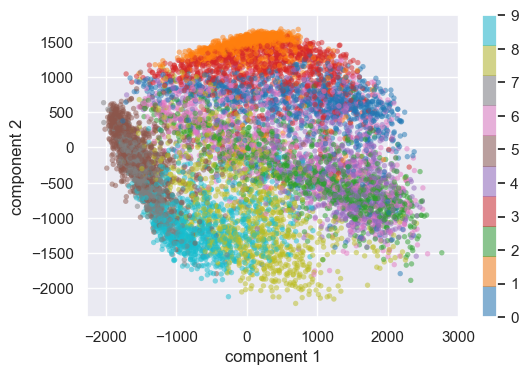

In [13]:
#plot results of PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
figure = plt.figure(dpi=100)
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y_test, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

## Task 4: Scikit Learn

## Supervised - kNN

I will be using the k-nearest neighbor classifier for this section. First, this model determines k number of points in the training dataset that are closest to the new testing data. It chooses the closest points by calculating the distance from the new data point to each of the labelled samples. Then it estimates the probability that the new data belongs to a particular label based on the k neighbors found earlier. Whichever label has the largest probability is then given to the new data. This probability can be computed with the following formula:
$$
P\big(y= j| \mathbf{x} \big)\approx  \frac{1}{k} \sum_{i\in \mathcal{N}_{x}} 1\{ y^{(i)} = j\}.
$$

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 6, metric='euclidean', n_jobs = -1) #look at the 6 closest neighbors
knn.fit(X_train, y_train) #train the model with the x and y training dataset
y_pred = knn.predict(X_test) #predict the labels (y) using the x test data
print('kNN score: ', knn.score(X_test,y_test)) # test the accuracy of kNN using the test dataset

kNN score:  0.8606


The kNN accurately classified 86.06% of testing dataset while the logistic regression model is 84.59% accurate.

## Unsupervised - IsoMap


In this section, I will use Isomap, a nonlinear dimensionality reduction method. This method uses kNN to search for k nearest neighbors and then the shortest path algorithm to compute the Geodesic distance. The goal is to preserve the computed Geodesic distance between the samples while still reducing the dimensions.

In [15]:
from sklearn.manifold import Isomap
isomap = Isomap(n_jobs = -1)
X_isomap = isomap.fit_transform(X_test) #since I used the x test dataset for pca, I used it again for isomap so that I can compare

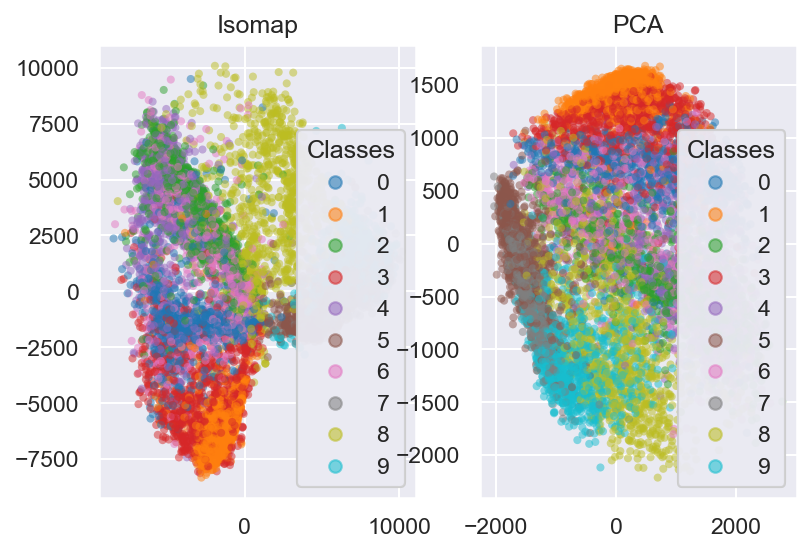

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2,dpi=150)

#plot isomap
fig1 = ax1.scatter(X_isomap[:, 0], X_isomap[:, 1],c=y_test, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('tab10', 10))
#plot pca from task 3
fig2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1],c=y_test, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('tab10', 10))
ax1.set_title('Isomap')
legend1 = ax1.legend(*fig1.legend_elements(), loc="best", title="Classes")
ax1.add_artist(legend1)
ax2.set_title('PCA')
legend2 = ax2.legend(*fig2.legend_elements(), loc="best", title="Classes")
ax2.add_artist(legend2)

## Task 5: Other Models


I will be using Tensorflow to classify the correct clothing item in the images.

In [17]:
import tensorflow as tf
print(tf.__version__)

C:\Users\adamg\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\adamg\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\adamg\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\adamg\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

1.14.0


In [18]:
train_images = X_train.reshape(60000,28,28) / 255.0
test_images = X_test.reshape(10000,28,28) / 255.0

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_images , y_train, epochs=10)
test_loss, test_acc = model.evaluate(test_images,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/10
60000/60000 [==============================] - 7s 115us/sample - loss: 0.5027 - acc: 0.8208
Epoch 2/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.3793 - acc: 0.8634
Epoch 3/10
60000/60000 [==============================] - 7s 113us/sample - loss: 0.3419 - acc: 0.8767
Epoch 4/10
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3177 - acc: 0.8836
Epoch 5/10
60000/60000 [==============================] - 7s 112us/sample - loss: 0.2967 - acc: 0.8907
Epoch 6/10
60000/60000 [==============================] - 7s 113us/sample - loss: 0.2841 - acc: 0.8947
Epoch 7/10
60000/60000 [==============================] - 7s 111us/sample - loss: 0.2720 - acc: 0.8994
Epoch 8/10
60000/60000 [==============================] - 7s 113us/sample - loss: 0.2605 - acc: 0.9029
Epoch 9/10
60000/60000 [==============================] - 

## Result

The deep learning model is 89.34% accurate.